# Visualizaion of spectral node counts with molecular family uniqueness

**Author**: Kyo Bin Kang (kbinkang@gmail.com) <br>

**Input file format**: 
<ul>
<li>**MS feature table** (.csv) with features in rows and samples in columns. Here we used a peak table retreived from Mzmine 2.</li>
<li>**GNPS feature-based molecular networking output table** (.tsv) with features in rows and associated data in columns. This file can be found in your GNPS output (/clusterinfo_summary). </li> 
</ul><br>

**Outputs**: A bar plot visualizing spectral node counts for each sample, with color showing uniqueness of molecular family. <br>

In [1]:
library(stringr)
library(dplyr)
library(reshape)
library(ggplot2)
library(RColorBrewer)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'reshape'

The following object is masked from 'package:dplyr':

    rename



In [2]:
# Load data
My.features <- read.table("Polyporaceae_Neg_mzmine200304_quant.csv", sep = ",", header=T, row.names = 1, comment.char="")
GNPS.table <- read.csv("f2128aea233542bbaf2d20e8c503c802.tsv", sep = "\t")
My.features <- subset(My.features, select= -c(row.m.z, row.retention.time))
colnames(My.features) <- str_replace_all(colnames(My.features), '_neg.mzXML.Peak.area','')

In [3]:
# Remove singletons (of which component index values are -1)
MF.features <- My.features[!(GNPS.table$componentindex == '-1'),]

In [4]:
# Filter MS features with intensities under 100. If you did not perform a gap-filling in Mzmine, you can skip this step.
MF.features[MF.features<100] <- 0
MF.features[MF.features>=100] <- 1

In [5]:
# Merge the feature table and the GNPS table to retrive component index
ci <- GNPS.table$componentindex[!(GNPS.table$componentindex == '-1')]
MF.features <- cbind(MF.features, ci)

In [6]:
# Count the number of sample occurrences per molecular family
ci.count <- aggregate(MF.features, list(componentindex = MF.features$ci), sum)
all.equal(unique(ci[order(ci)]), ci.count$componentindex)

[1] TRUE

In [7]:
ci.count <- subset(ci.count, select = -c(ci))
head(ci.count)

componentindex,KMRB15070728,KMRB15070723,KMRB16032507,KMRB15070765,KMRB15062619,KMRB15090213,KMRB17070402,KMRB17080804,KMRB15081403,...,KMRB15080602,KMRB16011521,KMRB15090836,KMRB17061910,KMRB17083132,KMRB16041505,KMRB15102011,KMRB15061217,KMRB14070116,KMRB15090322
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,2
2,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,2,0,0,...,0,1,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,...,3,0,0,2,0,3,3,1,0,2
6,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,2,2,0,0,0


In [8]:
# Calculate uniqueness index
ui <- rowSums(ci.count[,-1] !=0)

In [18]:
ci.count2 <- cbind(ci.count, ui)
ci.count_melt <- melt(ci.count2, id.vars=c("componentindex", "ui"))

In [19]:
# Define the level of uniqueness index and color palette for visualization
ui_levels <- (1:40)
q1 <- rev(colorRampPalette(brewer.pal(9, "YlOrRd"))(40))

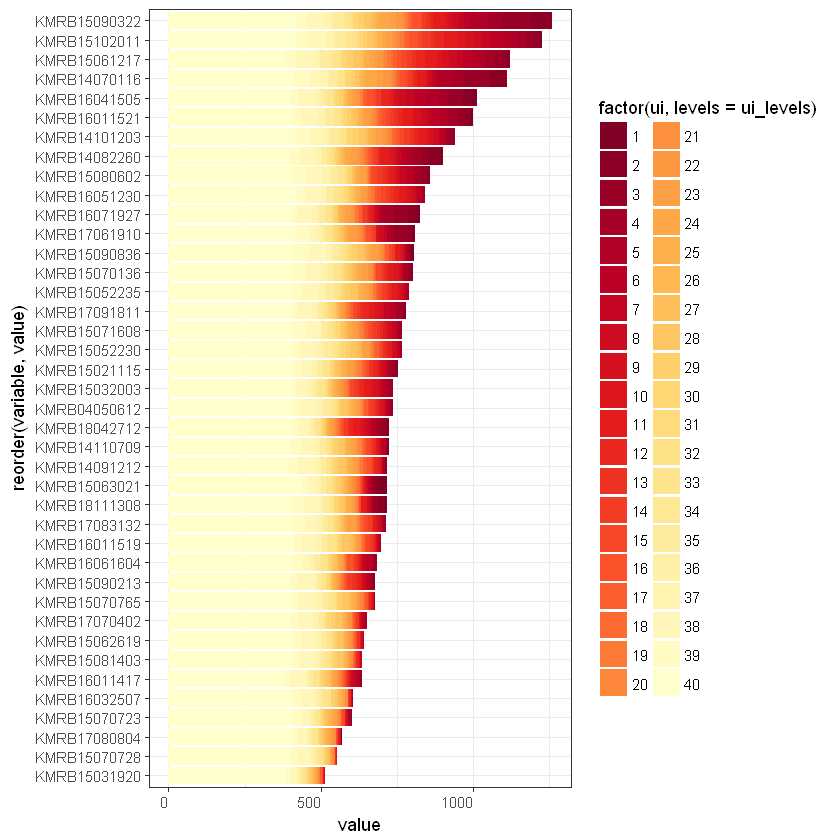

In [20]:
# Plot the bar plot with a legend
ggplot(ci.count_melt, aes(fill=factor(ui, levels = ui_levels), y=value, x=reorder(variable, value))) + 
    scale_fill_manual(values = q1) +
    geom_bar(position="stack", stat="identity") +
    theme_bw() +
    theme(axis.text.x = element_text(vjust = 0.5, hjust=1)) +
    coord_flip()

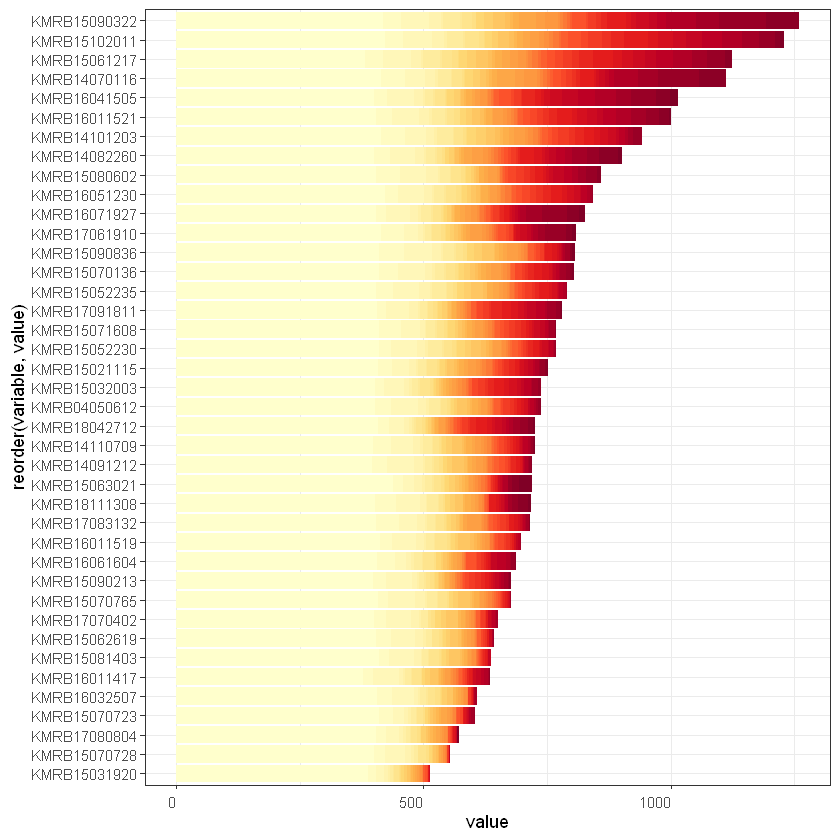

In [12]:
# Plot the bar plot without a legend
ggplot(ci.count_melt, aes(fill=factor(ui, levels = ui_levels), y=value, x=reorder(variable, value))) + 
    scale_fill_manual(values = q1) +
    geom_bar(position="stack", stat="identity") +
    theme_bw() +
    theme(axis.text.x = element_text(vjust = 0.5, hjust=1)) +
    theme(legend.title = element_blank()) + 
    theme(legend.position = 'none') + 
    coord_flip()

In [21]:
# Calculate MF index
mfi.count <- ci.count
mfi.count[mfi.count>=1] <- 1
mfi.count$componentindex <- ci.count$componentindex

In [22]:
mfi.count2 <- cbind(mfi.count, ui)
mfi.count_melt <- melt(mfi.count2, id.vars=c("componentindex", "ui"))

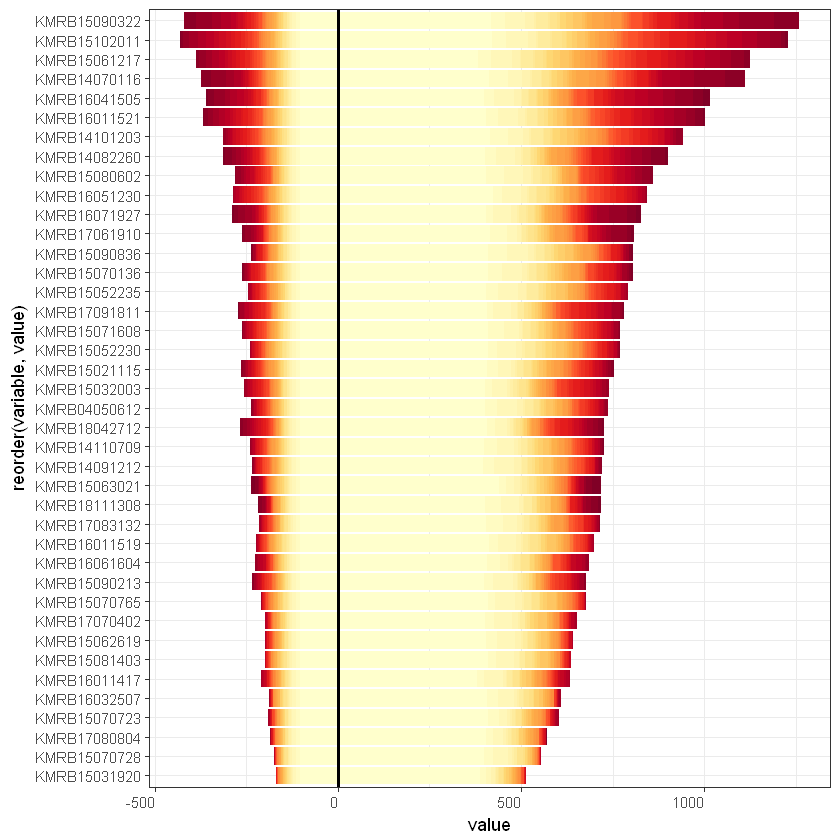

In [23]:
ggplot()+
    geom_bar(data=ci.count_melt, aes(fill=factor(ui, levels = ui_levels), y=value, x=reorder(variable, value)), stat="identity") +
    geom_bar(data=mfi.count_melt, aes(fill=factor(ui, levels = ui_levels), y=-value, x=reorder(variable,value)), stat="identity")+
    geom_hline(yintercept=0, lwd=1) +
    scale_fill_manual(values = q1) +
    theme_bw() +
    theme(axis.text.x = element_text(vjust = 0.5, hjust=1)) +
    theme(legend.title = element_blank()) + 
    theme(legend.position = 'none') + 
    coord_flip()

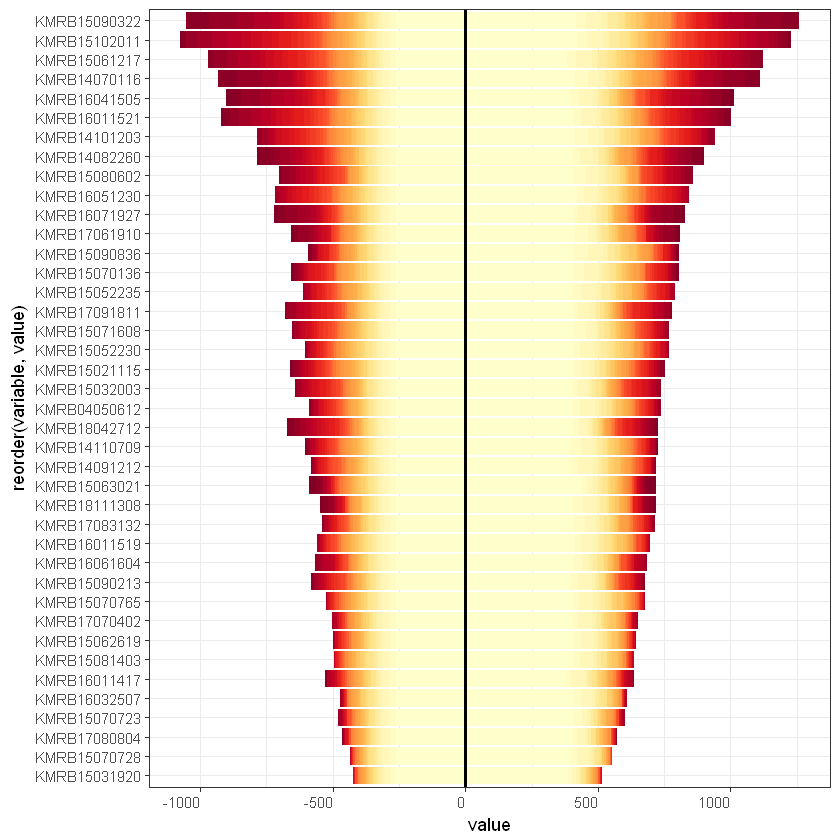

In [24]:
ggplot()+
    geom_bar(data=ci.count_melt, aes(fill=factor(ui, levels = ui_levels), y=value, x=reorder(variable, value)), stat="identity") +
    geom_bar(data=mfi.count_melt, aes(fill=factor(ui, levels = ui_levels), y=-2.5*value, x=reorder(variable,value)), stat="identity")+
    geom_hline(yintercept=0, lwd=1) +
    scale_fill_manual(values = q1) +
    theme_bw() +
    theme(axis.text.x = element_text(vjust = 0.5, hjust=1)) +
    theme(legend.title = element_blank()) + 
    theme(legend.position = 'none') + 
    coord_flip()